# Uncertainty in classification

inspired by https://towardsdatascience.com/uncertainty-in-deep-learning-brief-introduction-1f9a5de3ae04


## Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

tf.random.set_seed(84)
np.random.seed(84)

print('TF Version:', tf.__version__)
print('TFDS Version:', tfds.__version__)

TF Version: 2.13.0
TFDS Version: 4.9.3


## Image Classification Example with Fashion Minst Dataset


In [3]:
train_ds, test_ds = tfds.load('fashion_mnist', split = ['train', 'test'],
                             as_supervised = True)

train_ds = train_ds.batch(128).map(lambda x, y: (tf.cast(x / 255, tf.float32),
                                                tf.one_hot(y, 10))).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(128).map(lambda x, y: (tf.cast(x / 255, tf.float32),
                                                tf.one_hot(y, 10))).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteAJ39N0/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteAJ39N0/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation = 'swish',
                           input_shape = (28, 28, 1),
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(32, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(128, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.GlobalMaxPooling2D(),

    tf.keras.layers.Dense(128, activation = 'swish'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
             metrics = ['acc'])

model.summary()

model.fit(train_ds, epochs = 16, validation_data = test_ds)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

In [5]:
samples = []
labels = []

for x, y in test_ds.shuffle(buffer_size = 1024).take(1):
    samples.append(x.numpy())
    labels.append(np.argmax(y, axis = -1))

samples = np.squeeze(samples, axis = 0)
labels = np.squeeze(labels, axis = 0)
predictions = model.predict(samples)

assert samples.shape[0] == labels.shape[0]

4/4 [==============================] - 0s 4ms/step


In [ ]:
print(accuracy_score(labels, np.argmax(predictions, axis = -1)))

0.875


In [17]:
def plot_predictions(predictions, labels):
    plt.figure(figsize = (20, 16))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.bar(range(10), predictions[i], color = 'red')
        plt.bar(range(10), predictions[i] - 0.03,
               color='white', linewidth=1, edgecolor='white')
        plt.title('Predicted label: %d // True label: %d' % (np.argmax(predictions[i]),
                                                  labels[i]))
        plt.ylim([0, 1])
        plt.xticks(range(10))
        plt.ylabel('softmax score')
        plt.xlabel('class label')

    plt.tight_layout()
    plt.show()

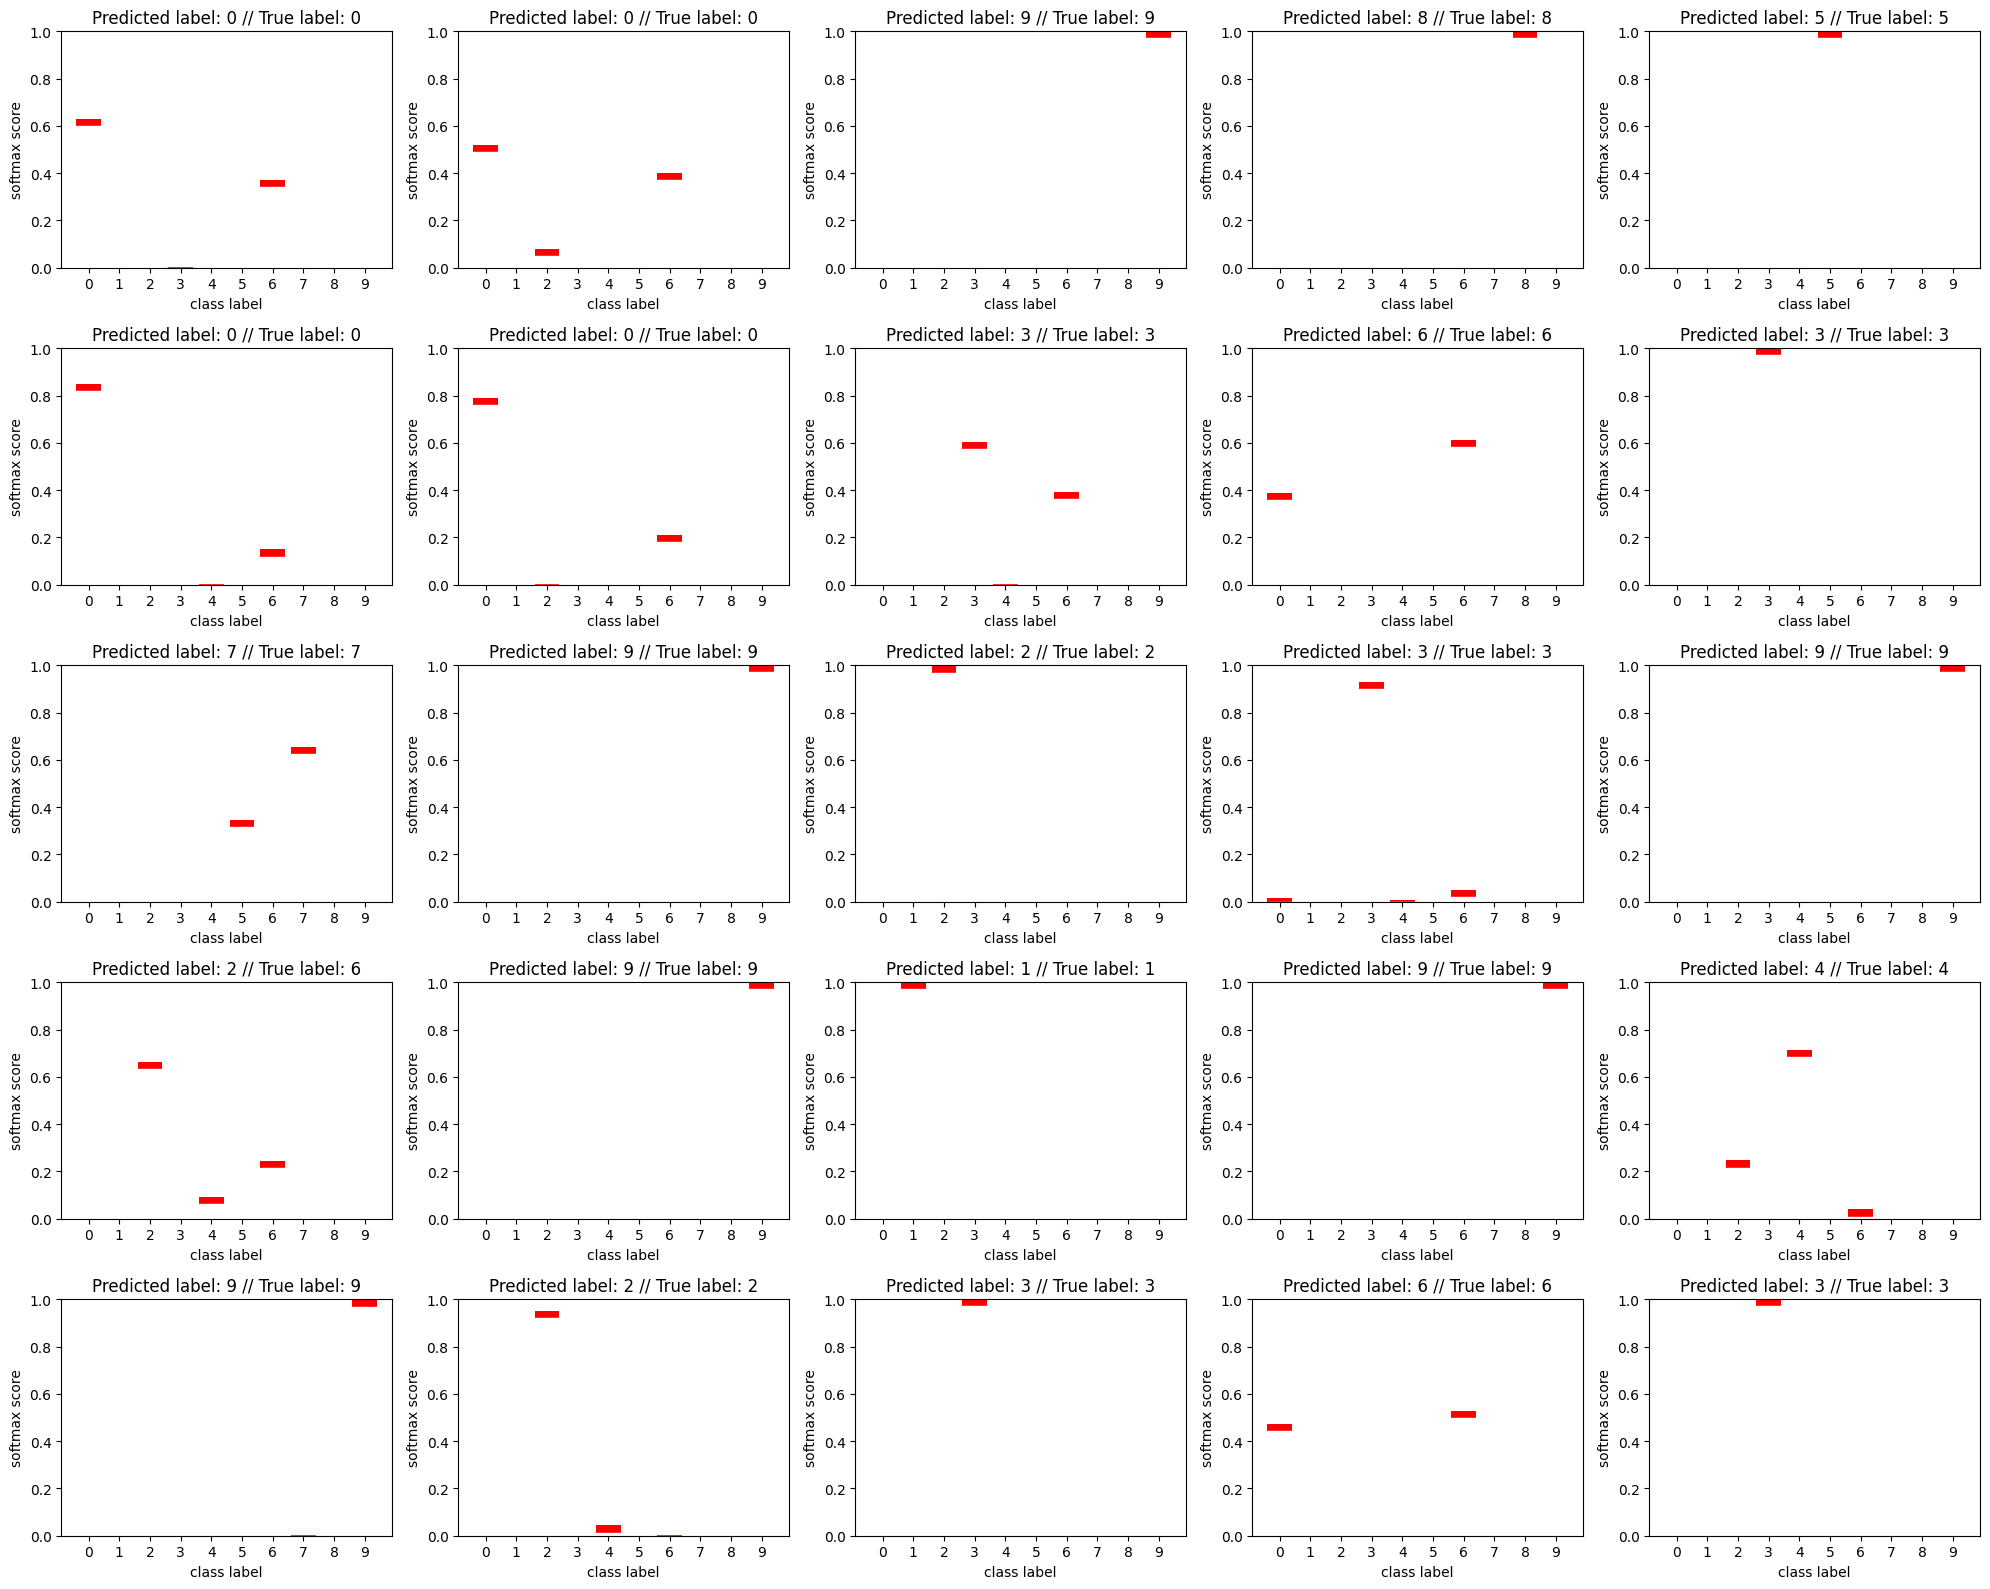

In [18]:
plot_predictions(predictions, labels)

In [8]:
random_vector = np.random.random(size = (28, 28, 1))
random_vector.max(), random_vector.min()

(0.9993302891183251, 0.002395005244030801)

In [11]:
def random_noise_prediction(model = None, random_vector = None, ensemble = False):
    if ensemble:
        predictions = []
        for i in range(ensemble):
            predictions.append(model(random_vector[np.newaxis, :],
                        training = True).numpy().squeeze())
        predict_noise = np.mean(predictions, axis = 0)
    else:
        predict_noise = model.predict(tf.expand_dims(random_vector,
                                              axis = 0)).squeeze()
    print({key:value for key, value in enumerate(predict_noise * 100)})

    plt.figure(figsize = (8, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(10), predict_noise, color = 'red')
    plt.bar(range(10), predict_noise - 0.01,
       color='white', linewidth=1, edgecolor='white')
    plt.grid(False)
    plt.xticks(range(10))
    plt.ylim([0, 1])
    plt.subplot(1, 2, 2)
    plt.imshow(random_vector.squeeze(), cmap = plt.cm.gray)
    plt.show()

1/1 [==============================] - 0s 238ms/step
{0: 0.15516183, 1: 25.172642, 2: 0.45611927, 3: 0.30543926, 4: 48.979397, 5: 0.008446495, 6: 2.7759264, 7: 0.108579084, 8: 21.918428, 9: 0.119857475}


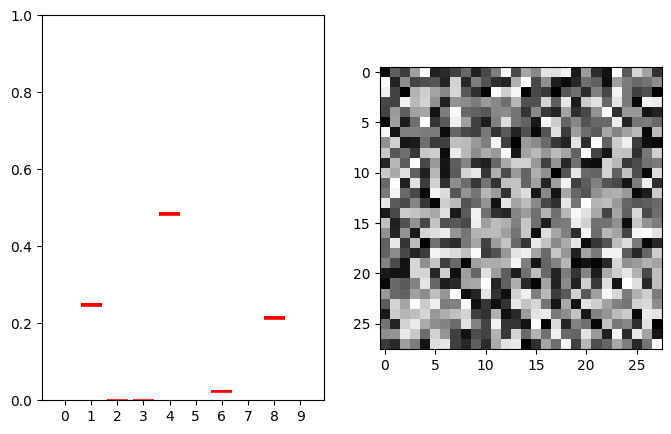

In [12]:
random_noise_prediction(model, random_vector)

In [13]:
for _ in range(5):
    predict_noise = model.predict(tf.expand_dims(random_vector,
                                             axis = 0)).squeeze()
    print('Softmax output for class 0:', predict_noise[0] * 100)

1/1 [==============================] - 0s 22ms/step
Softmax output for class 0: 0.15516183339059353
1/1 [==============================] - 0s 22ms/step
Softmax output for class 0: 0.15516183339059353
1/1 [==============================] - 0s 20ms/step
Softmax output for class 0: 0.15516183339059353
1/1 [==============================] - 0s 23ms/step
Softmax output for class 0: 0.15516183339059353
1/1 [==============================] - 0s 20ms/step
Softmax output for class 0: 0.15516183339059353


## Model with Dropouts

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation = 'swish', input_shape = (28, 28, 1),
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(32, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(64, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(128, 3, activation = 'swish',
                           padding = 'same'),
    tf.keras.layers.GlobalMaxPooling2D(),

    tf.keras.layers.Dense(128, activation = 'swish'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
             metrics = ['acc'])

model2.summary()

model2.fit(train_ds, epochs = 16, validation_data = test_ds)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)         

In [ ]:
for _ in range(4):
    predict_noise = model2(tf.expand_dims(random_vector,axis = 0),
                        training = True).numpy().squeeze()
    print('Softmax output for class 0:', predict_noise[0] * 100)

Softmax output for class 0: 3.7370428442955017
Softmax output for class 0: 4.5094069093465805
Softmax output for class 0: 0.9782549925148487
Softmax output for class 0: 1.7607659101486206


{0: 4.0112467, 1: 0.4843149, 2: 11.618713, 3: 8.531735, 4: 8.837839, 5: 0.04070336, 6: 59.83536, 7: 0.96540254, 8: 4.8854494, 9: 0.7892267}


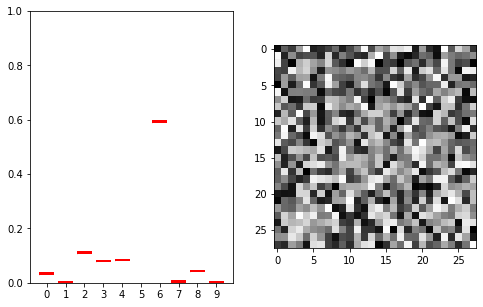

In [ ]:
random_noise_prediction(model2, random_vector, ensemble = 100)

In [ ]:
predictions = []
for _ in range(1000):
    predicted_ensemble = model2(samples,
                        training = True).numpy().squeeze()
    predictions.append(predicted_ensemble)
predictions = np.array(predictions)
print('Predictions shape:', predictions.shape)
predictions_median = np.median(predictions, axis = 0)

Predictions shape: (1000, 128, 10)


In [ ]:
predictions_median.shape

(128, 10)

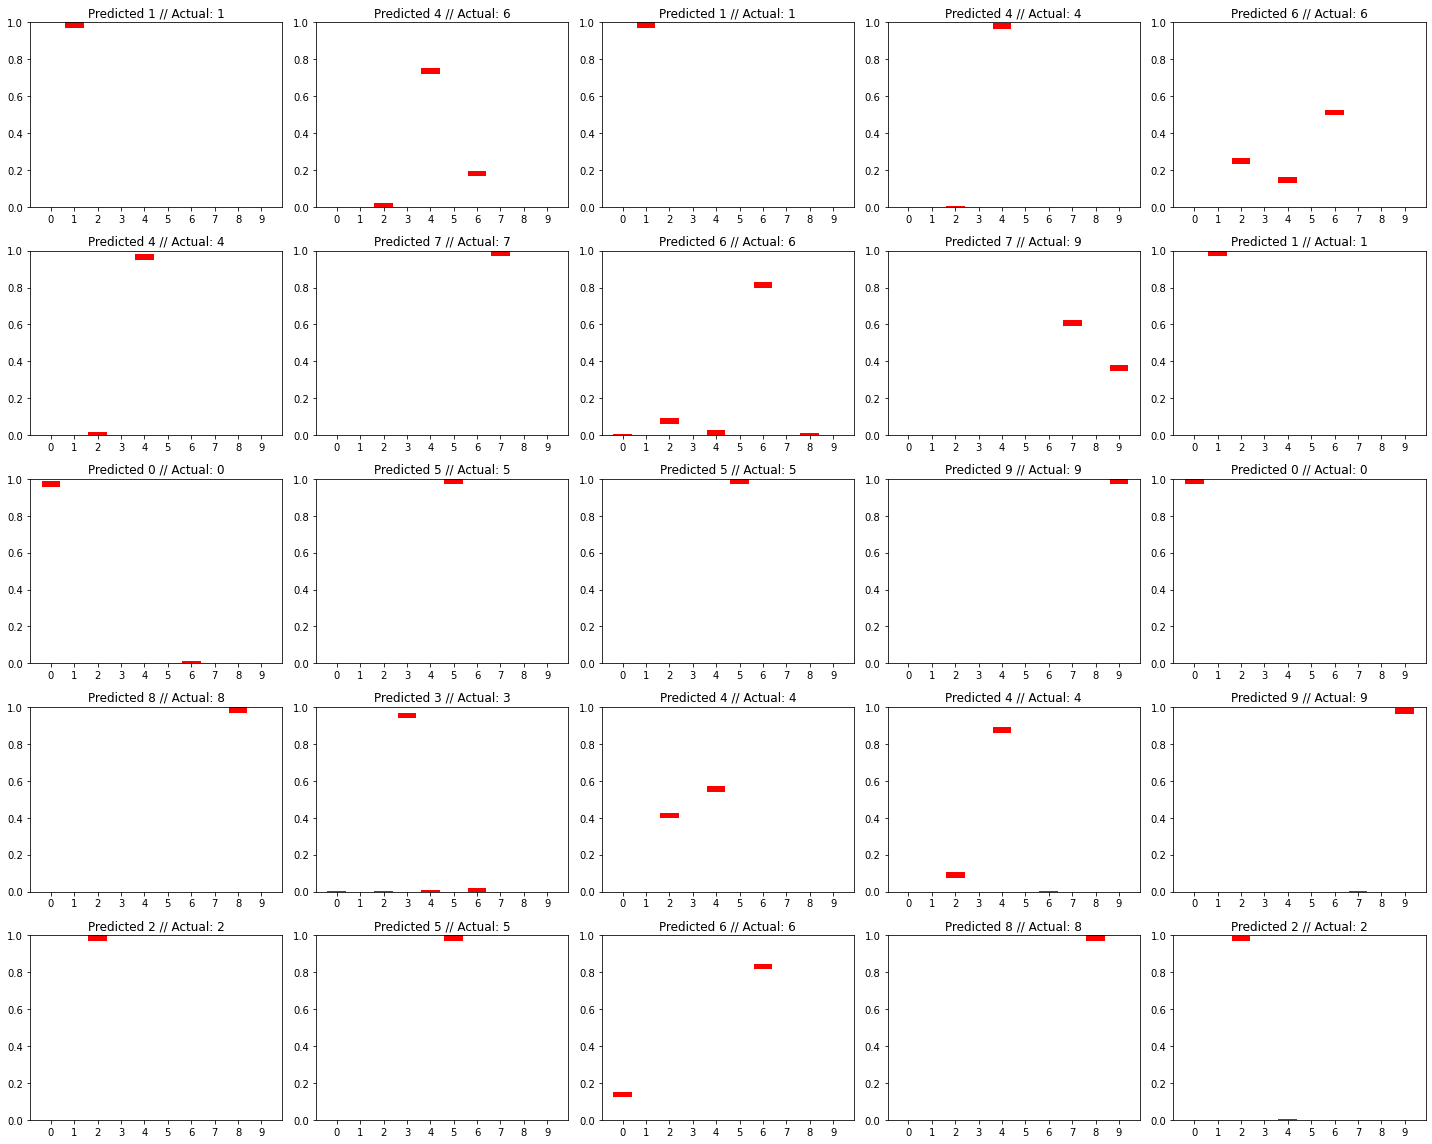

In [ ]:
plot_predictions(predictions_median, labels)

In [ ]:
print(accuracy_score(labels, np.argmax(predictions_median, axis = -1)))

0.8671875


## Samples with Confidence Intervals

In [ ]:
def plot_with_percentiles(prediction_normal,
                          prediction_dropout_ensemble):
    dropout_median_predictions = np.median(prediction_dropout_ensemble,
                                          axis = 0)
    ensemble_pct_97_5 = np.array([np.percentile(prediction_dropout_ensemble[:, j],
                                                97.5) for j in range(10)]).squeeze()
    ensemble_pct_2_5 = np.array([np.percentile(prediction_dropout_ensemble[:, j],
                                               2.5) for j in range(10)]).squeeze()

    fig, (ax1, ax2, ax3) = plt.subplots(figsize = (14, 5),
                                        nrows = 1, ncols = 3, sharex = True, sharey = True)
    plt.xticks(range(10))
    plt.ylim([0, 1])

    ax1.bar(range(10), prediction_normal.squeeze(), color = 'red')
    ax1.bar(range(10), prediction_normal.squeeze() - 0.03, color='white',
          linewidth=1, edgecolor='white')
    ax1.set_title('Softmax Output')

    ax2.bar(range(10), dropout_median_predictions, color = 'purple')
    ax2.bar(range(10), dropout_median_predictions.squeeze() - 0.03, color='white',
            linewidth=1, edgecolor='white')
    ax2.set_title('Dropout Ensemble Median')

    ax3.bar(range(10), ensemble_pct_97_5, color='green')
    ax3.bar(range(10), ensemble_pct_2_5 - 0.03, color='white',
          linewidth=1, edgecolor='white')
    ax3.set_title('Dropout Ensemble 95% CI')

    plt.show()

In [ ]:
def get_normal_and_ensemble_preds(samples = samples, model_normal = model,
                                 model_ensemble = model2,
                                 class_idx = 0, ensemble_size = 100):
    selected_sample = samples[class_idx]

    prediction_normal = model_normal.predict(selected_sample[np.newaxis, :])

    prediction_dropout = []
    for i in range(ensemble_size):
        prediction_i = model_ensemble(selected_sample[np.newaxis, :],
                            training = True).numpy().squeeze()
        prediction_dropout.append(prediction_i)
    prediction_dropout = np.array(prediction_dropout)
    return prediction_normal, prediction_dropout

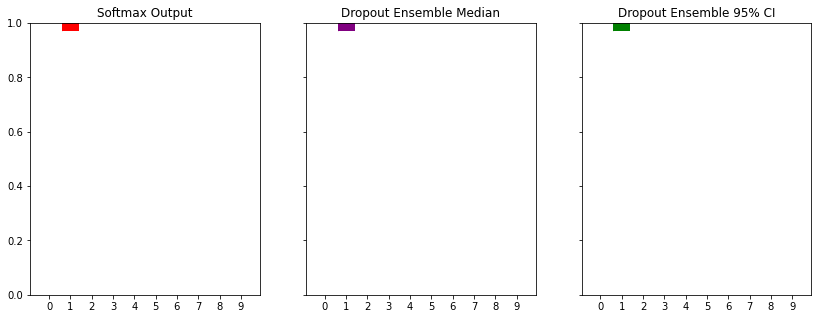

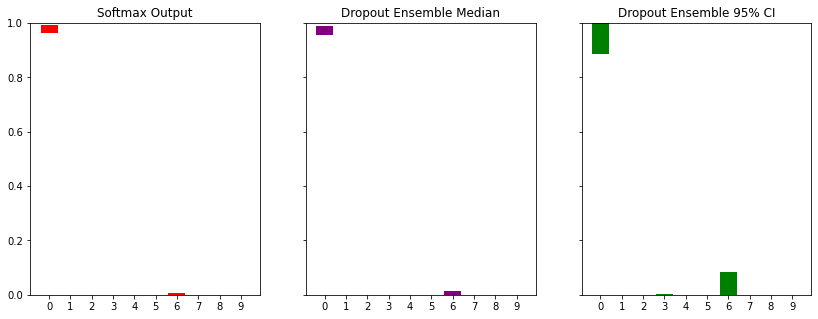

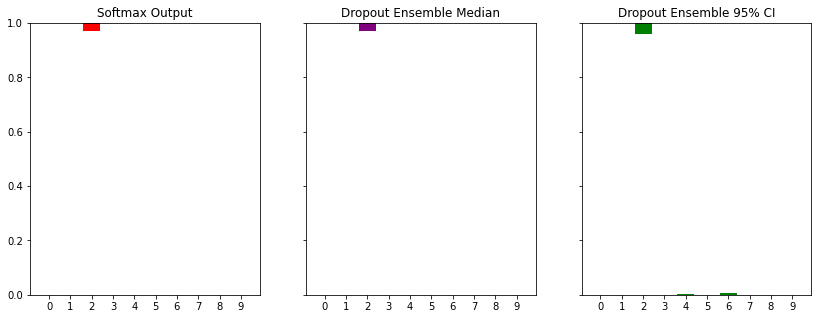

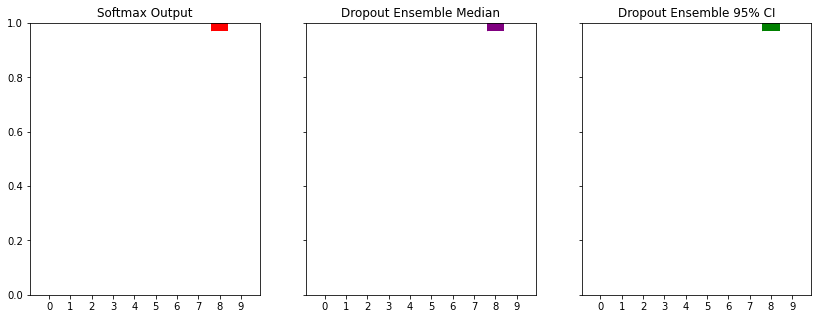

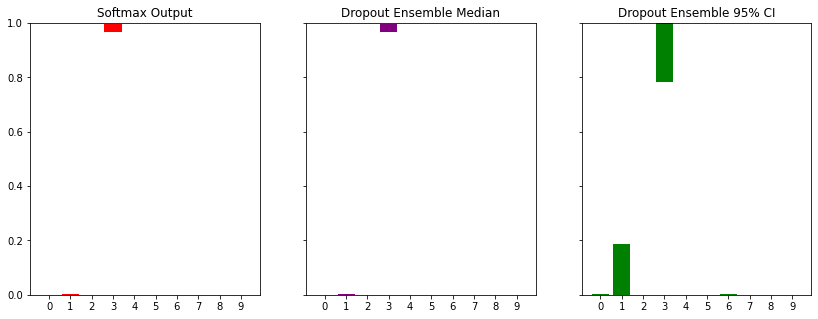

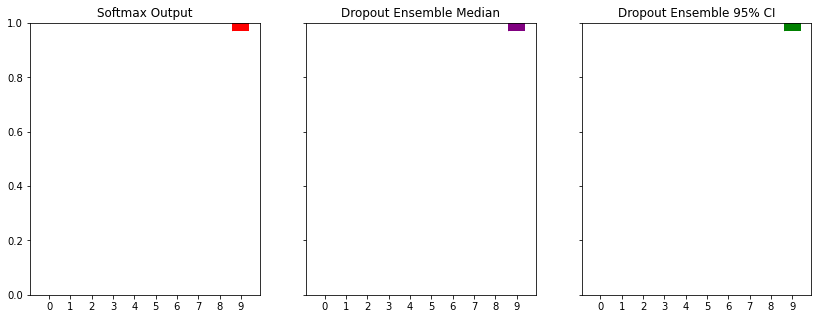

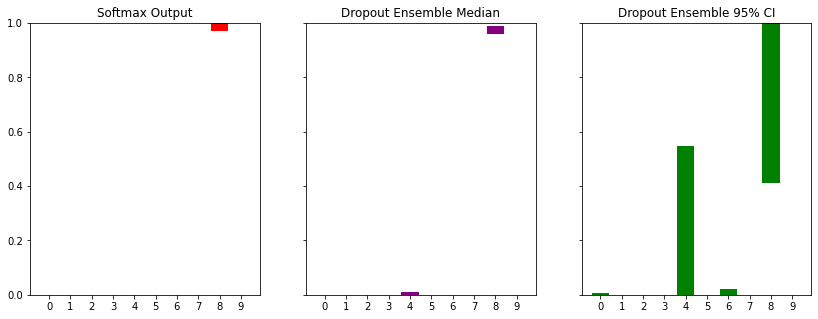

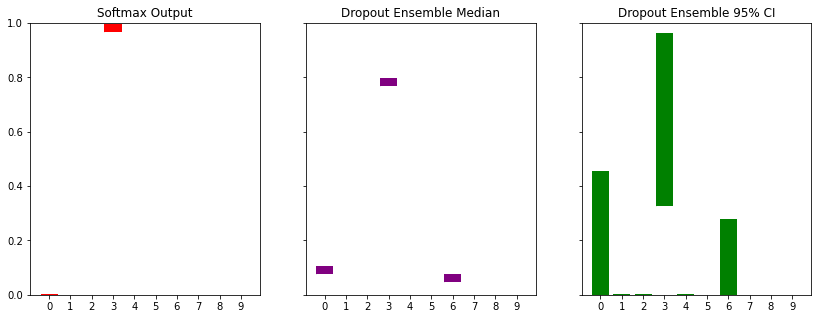

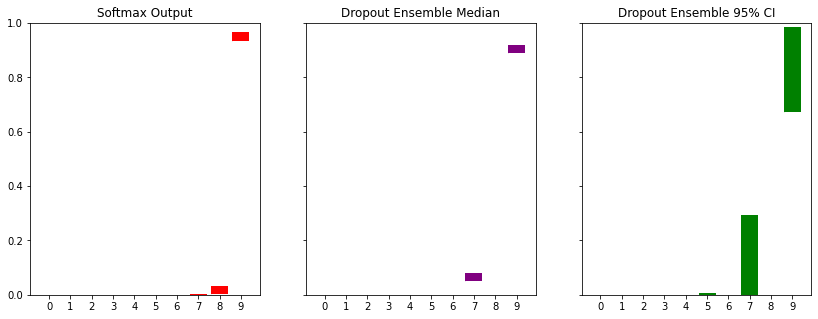

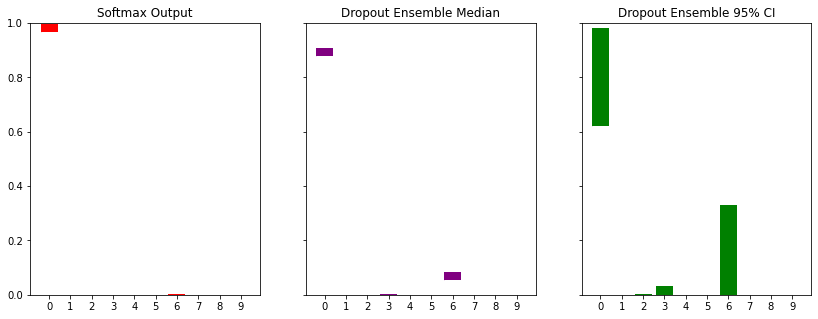

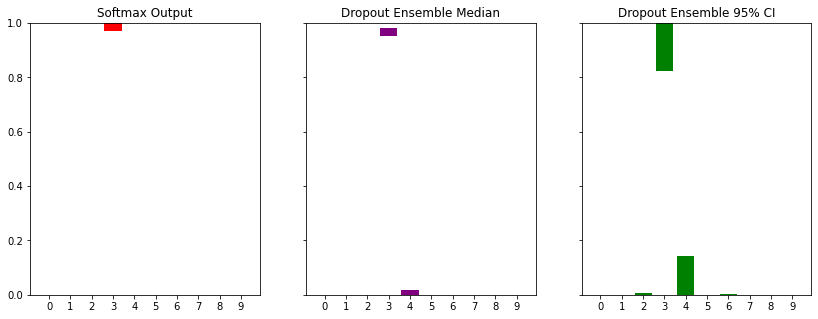

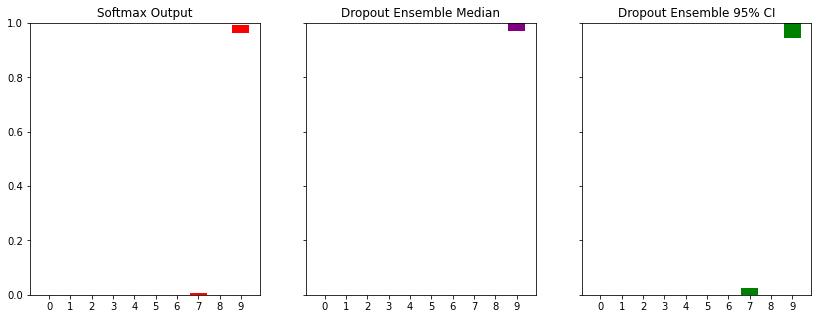

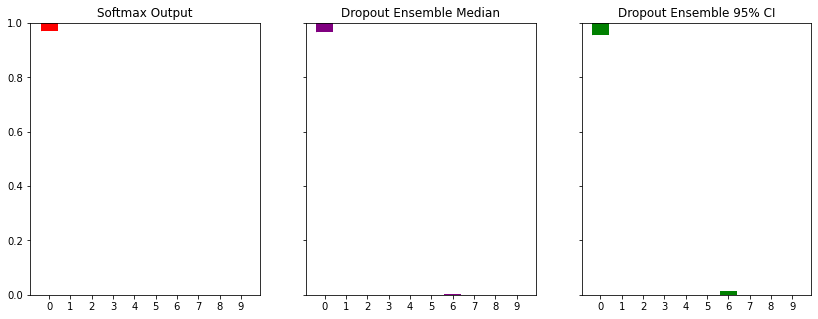

In [ ]:
for idx in [0, 10, 20, 25, 30, 36, 45, 50, 56, 64, 80, 92, 127]:
    prediction_normal, prediction_dropout_ensemble = get_normal_and_ensemble_preds(class_idx = idx,
                                                                                   ensemble_size = 1000)
    plot_with_percentiles(
            prediction_normal,
            prediction_dropout_ensemble
    )
    del prediction_normal, prediction_dropout_ensemble